最適な(s, S)政策: s=210, S=500
最小平均コスト: 1291464.40


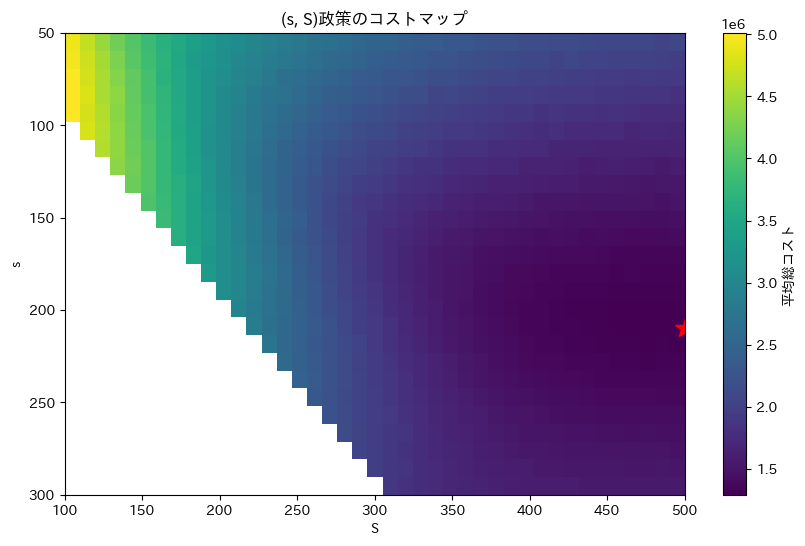

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.stats import uniform

class InventoryPolicySimulator:
    def __init__(self, D_mean, D_std, LT_min, LT_max, K, h, p, days):
        self.D_mean = D_mean  # 日次需要の平均
        self.D_std = D_std    # 日次需要の標準偏差
        self.LT_min = LT_min  # リードタイムの最小値
        self.LT_max = LT_max  # リードタイムの最大値
        self.K = K            # 1回の注文にかかる固定費用
        self.h = h            # 1個あたりの日次保管コスト
        self.p = p            # 1個あたりの品切れコスト
        self.days = days      # シミュレーション日数

    def simulate_inventory(self, s, S, num_simulations=100):
        total_costs = []
        
        for _ in range(num_simulations):
            inventory, cost = S, 0
            pending_order, days_until_delivery = 0, 0
            
            for _ in range(self.days):
                demand = max(0, int(np.random.normal(self.D_mean, self.D_std)))

                if days_until_delivery == 0 and pending_order > 0:
                    inventory += pending_order
                    pending_order = 0

                cost += self.p * max(0, demand - inventory) if inventory < demand else 0
                inventory = max(0, inventory - demand)
                cost += self.h * inventory
                
                if inventory <= s and pending_order == 0:
                    cost += self.K
                    pending_order = S - inventory
                    days_until_delivery = int(uniform.rvs(self.LT_min, self.LT_max))

                days_until_delivery = max(0, days_until_delivery - 1)

            total_costs.append(cost)
        
        return np.mean(total_costs)

    def grid_search(self, s_values, S_values):
        results = [(s, S, self.simulate_inventory(s, S)) for s in s_values for S in S_values if s < S]
        optimal = min(results, key=lambda x: x[2])
        print(f"最適な(s, S)政策: s={optimal[0]}, S={optimal[1]}")
        print(f"最小平均コスト: {optimal[2]:.2f}")
        return results, optimal

    def plot_cost_map(self, results, optimal):
        s_optimal, S_optimal, _ = optimal
        s_values_used = [r[0] for r in results]
        S_values_used = [r[1] for r in results]
        costs = np.array([r[2] for r in results])

        unique_s, unique_S = sorted(set(s_values_used)), sorted(set(S_values_used))
        cost_map = np.full((len(unique_s), len(unique_S)), np.nan)
        for s, S, cost in results:
            cost_map[unique_s.index(s), unique_S.index(S)] = cost

        plt.figure(figsize=(10, 6))
        plt.imshow(cost_map, cmap='viridis', aspect='auto', 
                   extent=[min(unique_S), max(unique_S), max(unique_s), min(unique_s)])
        plt.colorbar(label='平均総コスト')
        plt.xlabel('S')
        plt.ylabel('s')
        plt.title('(s, S)政策のコストマップ')
        plt.plot(S_optimal, s_optimal, 'r*', markersize=15)
        plt.show()

simulator = InventoryPolicySimulator(D_mean=40, D_std=10, LT_min=2, LT_max=5, K=10000, h=10, p=500, days=365)
s_values = range(50, 301, 10)
S_values = range(100, 501, 10)
results, optimal = simulator.grid_search(s_values, S_values)
simulator.plot_cost_map(results, optimal)
